# Set-Up

In [3]:
!pip install pyvista
!pip install matplotlib
!pip install pygmsh

     |████████████████████████████████| 1.4 MB 6.0 MB/s eta 0:00:01
     |████████████████████████████████| 59.5 MB 59 kB/s  eta 0:00:011   |█                               | 1.8 MB 9.7 MB/s eta 0:00:06     |██▏                             | 3.9 MB 9.7 MB/s eta 0:00:06     |█████▍                          | 10.0 MB 11.5 MB/s eta 0:00:05     |████████▉                       | 16.3 MB 7.0 MB/s eta 0:00:07     |█████████▊                      | 18.0 MB 7.0 MB/s eta 0:00:06     |████████████████████▋           | 38.3 MB 5.6 MB/s eta 0:00:04     |███████████████████████         | 42.8 MB 8.8 MB/s eta 0:00:02     |██████████████████████████████▌ | 56.8 MB 6.7 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 12.1 MB/s eta 0:00:01
     |████████████████████████████████| 158 kB 13.1 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 11.0 MB/s eta 0:00:01
     |████████████████████████████████| 495 kB 9.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.5 MB

In [4]:
# MUST RUN THIS CELL:
!pip uninstall -y h5py
!pip install h5py==2.9.0

     |████████████████████████████████| 287 kB 5.8 MB/s eta 0:00:01
  Created wheel for h5py: filename=h5py-2.9.0-cp39-cp39-linux_x86_64.whl size=4691373 sha256=6b962a52a158ee2611d591f61aa38ff771b4576999fdac4072a4a80527e3d2a0
  Stored in directory: /root/.cache/pip/wheels/ef/54/5c/3fbdb9cfe071661699815cfd6b71ddf2d12d61d121a109a5e0
Successfully built h5py


In [1]:
import dolfinx
import numpy as np
from mpi4py import MPI
from dolfinx.cpp.mesh import CellType
import dolfinx.io
import pyvista
import dolfinx.plot
from math import sin, cos, pi
import pygmsh
import gmsh
import meshio
import ufl
from math import ceil, floor
from petsc4py import PETSc

# Function Definitions

## Mesh Creation

In [2]:
def create_mesh(L, W, mesh_size, num_layers):
    with pygmsh.geo.Geometry() as geom:
        # Define cross-section:
        poly = geom.add_polygon([[0.0, 0.0, 0.0],
                                 [0.0, W, 0.0],
                                 [L, W, 0.0],
                                 [L, 0.0, 0.0]], mesh_size=mesh_size)
        geom.extrude(poly, [0.0, 0.0, W], num_layers=num_layers)
        pygmsh_mesh = geom.generate_mesh(dim=3)
        pygmsh.write('beam_mesh.msh')
    mesh3D_from_msh = meshio.read("beam_mesh.msh")
    cells = mesh3D_from_msh.get_cells_type("tetra")
    tetra_mesh = meshio.Mesh(points=mesh3D_from_msh.points, cells={"tetra": cells})
    
    meshio.write("beam_mesh.xdmf", tetra_mesh)
    with dolfinx.io.XDMFFile(MPI.COMM_WORLD, "beam_mesh.xdmf", 'r') as f:
        mesh = f.read_mesh(name="Grid")
    
    return mesh

## Function to Define Young's Modulus Field

In [3]:
def create_beam_layers(E_list, mesh, nu, W):
    
    num_layers = len(E_list)
    
    # Compute coordinates of interfaces:
    interfaces = [i*W/num_layers for i in range(num_layers)]
    interfaces.append(W)
    
    # Declare lambda_ and mu as function on mesh:
    Q = dolfinx.FunctionSpace(mesh, ("DG", 0))
    lambda_ = dolfinx.Function(Q)
    mu = dolfinx.Function(Q)
    
    
    # Iterate over layers in beam and find cells in each layer:
    cells_list = []
    
    for i in range(num_layers):
        
        # Unpack i'th lambda value and interfaces:
        x_start, x_end = interfaces[i], interfaces[i+1]
        
        # Create function to identify cells in this layer:
        boundary_fun = create_boundary_function(x_start, x_end)
        
        cells_list.append(dolfinx.mesh.locate_entities(mesh, mesh.topology.dim, boundary_fun))
    
    # Set layer values now:
    lambda_list = [E_i*nu/((1+nu)*(1-2*nu)) for E_i in E_list]
    mu_list = [E_i/(2*(1+nu)) for E_i in E_list]
    for field_j, param_field in enumerate([lambda_, mu]): 
        with param_field.vector.localForm() as loc:
            for i in range(num_layers):
                cells_i = cells_list[i]
                value = lambda_list[i] if field_j==0 else mu_list[i]
                loc.setValues(cells_i, np.full(len(cells_i), value))
    
    return (lambda_, mu, cells_list)

def create_boundary_function(x_start, x_end):
    def boundary(x):
        # Need to round, or else will get assignment errors:
        return (x[2] >= floor(x_start)) & (x[2] <= ceil(x_end))
    return boundary

## Function to Apply Load to Beam

In [19]:
def apply_loading(E_list, beam_angle, nu, L, W, rho, g, mesh_size, elements_per_layer, elem_order, num_steps):
    
    beam_angle *= pi/180
    
    num_layers = elements_per_layer * len(E_list)
    
    mesh = create_mesh(L, W, mesh_size, num_layers)
    V = dolfinx.VectorFunctionSpace(mesh, ("CG", elem_order))
    
    # Create lambda and mu fields:
    lambda_, mu, cells_list = create_beam_layers(E_list, mesh, nu, W)
    
    # Apply fixed BC:
    left = lambda x: np.isclose(x[0], 0)
    right = lambda x: np.isclose(x[0], L)
    left_facets = dolfinx.mesh.locate_entities_boundary(mesh, mesh.topology.dim - 1, left)
    right_facets = dolfinx.mesh.locate_entities_boundary(mesh, mesh.topology.dim - 1, right)
    marked_facets = np.hstack([left_facets, right_facets])
    marked_values = np.hstack([np.full(len(left_facets), 1, dtype=np.int32), np.full(len(right_facets), 2, dtype=np.int32)])
    sorted_facets = np.argsort(marked_facets)
    facet_tag = dolfinx.MeshTags(mesh, mesh.topology.dim-1, marked_facets[sorted_facets], marked_values[sorted_facets])
    u_bc = dolfinx.Function(V)
    with u_bc.vector.localForm() as loc:
        loc.set(0)
    left_dofs = dolfinx.fem.locate_dofs_topological(V, facet_tag.dim, facet_tag.indices[facet_tag.values==1])
    bcs = [dolfinx.DirichletBC(u_bc, left_dofs)]
    
    B = dolfinx.Constant(mesh, (0, 0, 0))
    T = dolfinx.Constant(mesh, (0, 0, 0))
    v = ufl.TestFunction(V)
    u = dolfinx.Function(V)

    d = len(u)
    I = ufl.variable(ufl.Identity(d))
    F = ufl.variable(I + ufl.grad(u))
    C = ufl.variable(F.T * F)
    Ic = ufl.variable(ufl.tr(C))
    J  = ufl.variable(ufl.det(F))
    psi = (mu / 2) * (Ic - 3) - mu * ufl.ln(J) + (lambda_ / 2) * (ufl.ln(J))**2
    P = ufl.diff(psi, F)
    
    metadata = {"quadrature_degree": elem_order}
    ds = ufl.Measure('ds', subdomain_data=facet_tag, metadata=metadata)
    dx = ufl.Measure("dx", metadata=metadata)
    F = ufl.inner(ufl.grad(v), P)*dx - ufl.inner(v, B)*dx - ufl.inner(v, T)*ds(2) 
    
    problem = dolfinx.fem.NonlinearProblem(F, u, bcs)
    solver = dolfinx.NewtonSolver(MPI.COMM_WORLD, problem)

    solver.atol = 1e-3
    solver.rtol = 1e-3
    solver.convergence_criterion = "incremental"
    
    f_step = rho*g/num_steps
    for n in range(num_steps):
        print(f"Performing load step {n+1}/{num_steps}")
        B.value[0] = (n+1)*f_step*cos(beam_angle)
        B.value[2] = -(n+1)*f_step*sin(beam_angle)
        num_its, converged = solver.solve(u)
        assert(converged)
        u.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
    
    return (u, mesh, cells_list)

## Function to Plot Beam Deformation

In [5]:
def plot_deformation(mesh, uh):
    
    pyvista.start_xvfb(wait=0.05)
    topology, cell_types = dolfinx.plot.create_vtk_topology(mesh, mesh.topology.dim)
    grid = pyvista.UnstructuredGrid(topology, cell_types, mesh.geometry.x)
    
    p = pyvista.Plotter(window_size=[960,480])
    
    p.add_text("Deformed configuration", name="title", position="upper_edge")
    
    grid["u"] = uh.compute_point_values().real 
    actor_0 = p.add_mesh(grid, style="wireframe", color="k")
    warped = grid.warp_by_vector("u", factor=1.5)
    actor_1 = p.add_mesh(warped)
    
    p.show_axes()
    p.show()

## Function to Visualise Beam Layers

In [23]:
def visualise_layers(E_list, mesh, cells_list):
    
    pyvista.start_xvfb(wait=0.05)
    topology, cell_types = dolfinx.plot.create_vtk_topology(mesh, mesh.topology.dim)
    grid = pyvista.UnstructuredGrid(topology, cell_types, mesh.geometry.x)
    
    p = pyvista.Plotter(window_size=[960,480])
    
    # Add title:
    p.add_text("Beam layers", name="title", position="upper_edge")
   
    num_cells_local = mesh.topology.index_map(mesh.topology.dim).size_local
    E_marker = np.zeros(num_cells_local, dtype=np.int32)
    
    for i, cell_i in enumerate(cells_list):
        cells_to_mark = cell_i[cell_i<num_cells_local]
        E_marker[cells_to_mark] = E_list[i]
        
    topology, cell_types = dolfinx.plot.create_vtk_topology(mesh, mesh.topology.dim, np.arange(num_cells_local, dtype=np.int32))
    grid = pyvista.UnstructuredGrid(topology, cell_types, mesh.geometry.x)
    grid.cell_data["E"] = E_marker
    grid.set_active_scalars("E") 
    
    # Add mesh to plotter and visualize
    actor = p.add_mesh(grid, show_edges=True)
    p.show_axes()
    p.show()

# Call Functions

In [34]:
# Fixed parameters:
mesh_size= 10
elements_per_layer = 5
elem_order = 2
W = 40 # in mm
L = 90 # in mm
nu = 0.33 # dimensionless
rho = 0.00102 # in g mm^-3
g = 9.81 # in m s^-2
num_steps = 5

# Variables:
beam_angle = 90
E_list =  [100, 10, 50] # in mPa

In [35]:
# First, apply loading:
uh, mesh, cells_list = apply_loading(E_list, beam_angle, nu, L, W, rho, g, mesh_size, 
                                     elements_per_layer, elem_order, num_steps)

Performing load step 1/5
Performing load step 2/5
Performing load step 3/5
Performing load step 4/5
Performing load step 5/5


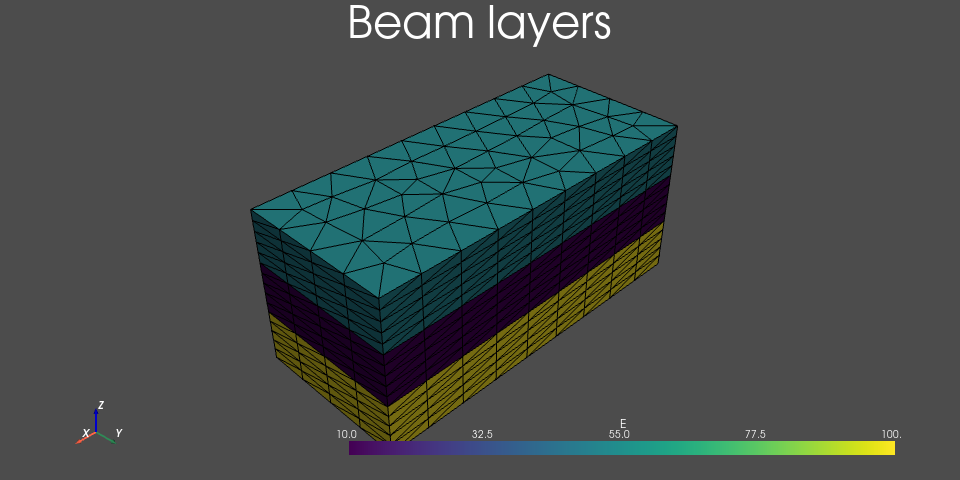

In [36]:
# Next, visualise beam layers:
visualise_layers(E_list, mesh, cells_list)

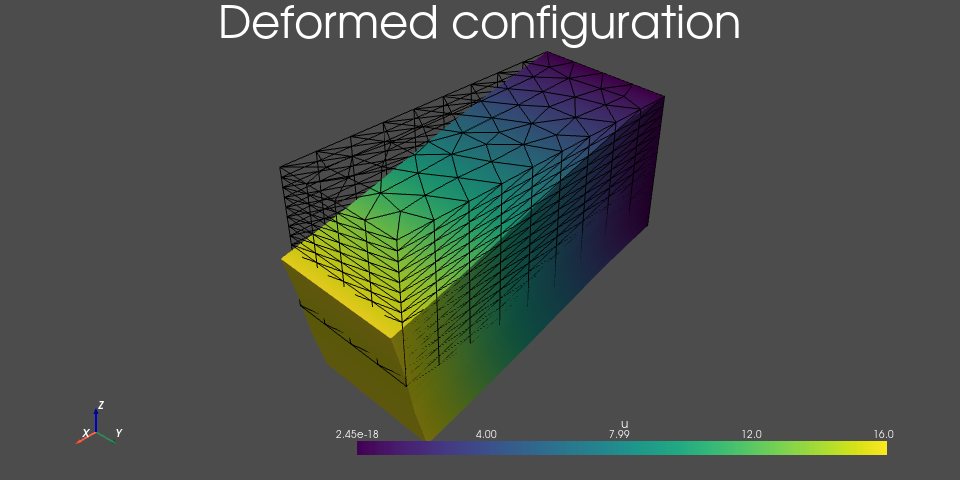

In [37]:
# Finally, visualise beam deflection:
plot_deformation(mesh, uh)